In [2]:
import matplotlib.pyplot as plt
import numpy as np


In [3]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [4]:
#데이터 셋
X, Y = make_moons(n_samples=500, noise=0.3)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [5]:
#보팅
Voting_clf = VotingClassifier(
 estimators =[
     ('lr', LogisticRegression()),
     ('rf', RandomForestClassifier()),
     ('svc', SVC())
 ]
)

Voting_clf.fit(X_train, Y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
#보팅 안에 있는 각 모델의 성능 확인
for n, cls in Voting_clf.named_estimators_.items():
  print(f"{n} = {cls.score(X_test, Y_test)}")

lr = 0.83
rf = 0.96
svc = 0.94


In [7]:
# classifier 안에서 의견을 모았을 경우 성능
Voting_clf.score(X_test, Y_test)

0.95

In [8]:
# 동일한 테스트 데이터에 대해 각 분류기와 보팅 분류기가 어떤 의견을 내는지 확인
Voting_clf.predict(X_test[:1])

array([1])

In [9]:
[clf.predict(X_test[:1]) for clf in Voting_clf.estimators_]

[array([1]), array([1]), array([1])]

In [10]:
# 소프트 보팅으로 변환
Voting_clf.voting = "soft"

# 옵션 변환을 위해 named_estimator로 가져옴 -> probability 옵션
Voting_clf.named_estimators["svc"].probability = True

# 훈련
Voting_clf.fit(X_train, Y_train)
Voting_clf.score(X_test, Y_test)

0.95

## 배깅

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
 DecisionTreeClassifier(), n_estimators=500,
 # max_samples 각 결정 트리가 학습할 샘플의 수
 # n_jobs = CPU를 모두 사용해서 병렬 학습
 max_samples=100, n_jobs=-1
)

bag_clf.fit(X_train, Y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

In [12]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.96

In [13]:
# oob를 통한 검증
bag_clf = BaggingClassifier(
 DecisionTreeClassifier(), n_estimators=500,
 oob_score=True, n_jobs=-1
)
bag_clf.fit(X_train, Y_train)
bag_clf.oob_score_

0.92

## AdaBoost를 활용하기

In [14]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
 DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.5
)
ada_clf.fit(X_train, Y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [15]:
y_pred = ada_clf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.96

## 그래디언트 부스트

In [16]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
Y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.7)

gbr.fit(X, Y)

GradientBoostingRegressor(learning_rate=0.7, max_depth=2, n_estimators=3)

In [18]:
# 그래디언트 부스트가 회귀 선을 추정한 것을 시각화 하기 위한 코드

def plot_predictions(reg, X, Y, axes, style, label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regr.predict(x1.reshape(-1, 1)) for regr in reg)

    plt.plot(X[:, 0], Y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

<ipython-input-18-3c7469f42aca>:11: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis(axes)


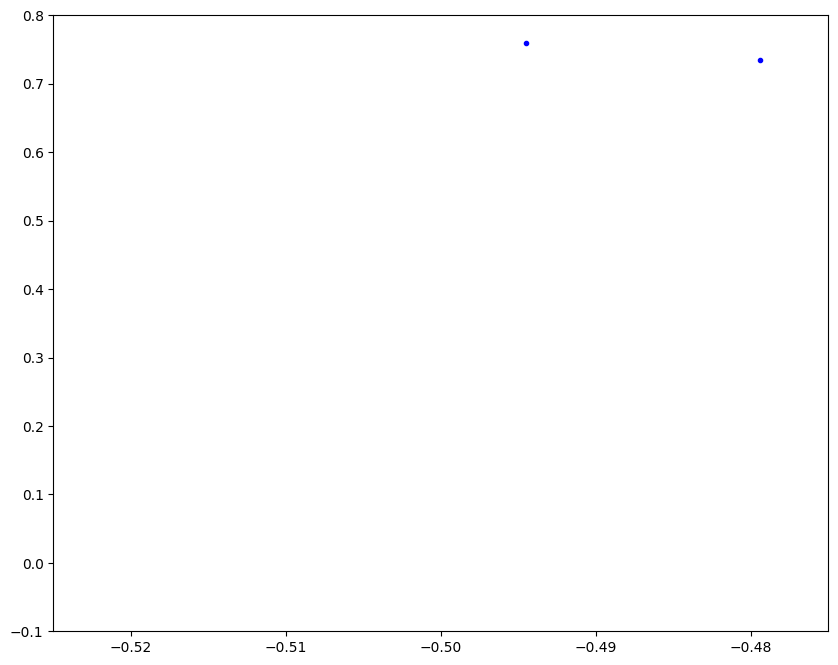

In [19]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 8))

plot_predictions([gbr], X,Y, axes=[-0.5, -.5, -0.1, 0.8],
                 style="r-")
plt.show()

## 스태킹

In [20]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ],
    final_estimator = RandomForestClassifier(),
    cv=5
)
stacking_clf.fit(X_train, Y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('rf', RandomForestClassifier()),
                               ('svc', SVC(probability=True))],
                   final_estimator=RandomForestClassifier())

In [21]:
stacking_clf.score(X_test, Y_test)

0.96